In [1]:
import gradio as gr
import torch
from src.train import train
from sklearn.datasets import load_breast_cancer

In [2]:
X, y = load_breast_cancer(return_X_y=True)
    
model,data = train(X=X, y=y)

Target labels: [0 1]


wandb: Currently logged in as: lamastico2-0 (lamastico2-0-hes-so-valais-wallis) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: Detected [huggingface_hub.inference] in use.
wandb: Use W&B Weave for improved LLM call tracing. Install Weave with `pip install weave` then add `import weave` to the top of your script.
wandb: For more information, check out the docs at: https://weave-docs.wandb.ai/


lr: 0.001
Epoch 01 | Loss: 0.7607 | Acc: 0.3519 | Val Loss: 0.7588 | Val Acc: 0.3772
Epoch 02 | Loss: 0.7574 | Acc: 0.3548 | Val Loss: 0.7560 | Val Acc: 0.3772
Epoch 03 | Loss: 0.7542 | Acc: 0.3548 | Val Loss: 0.7533 | Val Acc: 0.3772
Epoch 04 | Loss: 0.7510 | Acc: 0.3578 | Val Loss: 0.7505 | Val Acc: 0.3772
Epoch 05 | Loss: 0.7478 | Acc: 0.3607 | Val Loss: 0.7478 | Val Acc: 0.3772
Epoch 06 | Loss: 0.7447 | Acc: 0.3636 | Val Loss: 0.7449 | Val Acc: 0.3772
Epoch 07 | Loss: 0.7415 | Acc: 0.3636 | Val Loss: 0.7421 | Val Acc: 0.3772
Epoch 08 | Loss: 0.7383 | Acc: 0.3636 | Val Loss: 0.7392 | Val Acc: 0.3772
Epoch 09 | Loss: 0.7350 | Acc: 0.3636 | Val Loss: 0.7363 | Val Acc: 0.3772
Epoch 10 | Loss: 0.7317 | Acc: 0.3636 | Val Loss: 0.7334 | Val Acc: 0.3772
Epoch 11 | Loss: 0.7283 | Acc: 0.3636 | Val Loss: 0.7303 | Val Acc: 0.3772
Epoch 12 | Loss: 0.7248 | Acc: 0.3636 | Val Loss: 0.7271 | Val Acc: 0.3772
Epoch 13 | Loss: 0.7212 | Acc: 0.3666 | Val Loss: 0.7239 | Val Acc: 0.3772
Epoch 14 | Loss

Train Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▃▃▄▄▅▆▆▇▇▇▇▇██████████
Train Loss,█████▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▁▁
Val Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▄▅▅▅▇▇▇▇███████████
Val Loss,█████▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▁
Train Accuracy,0.93548
Train Loss,0.49803
Val Accuracy,0.92105
Val Loss,0.51686


In [3]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [4]:
model.eval()
with torch.no_grad():
    y_pred_probs = model(data["X_test_tensor"])
    y_pred = (y_pred_probs > 0.5).int()

In [5]:
y_pred_np = y_pred.numpy().flatten()
y_true_np = data["y_test_tensor"].numpy().flatten()

print(classification_report(y_true_np, y_pred_np, target_names=["malignant", "benign"]))


              precision    recall  f1-score   support

   malignant       0.97      0.93      0.95        42
      benign       0.96      0.99      0.97        72

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



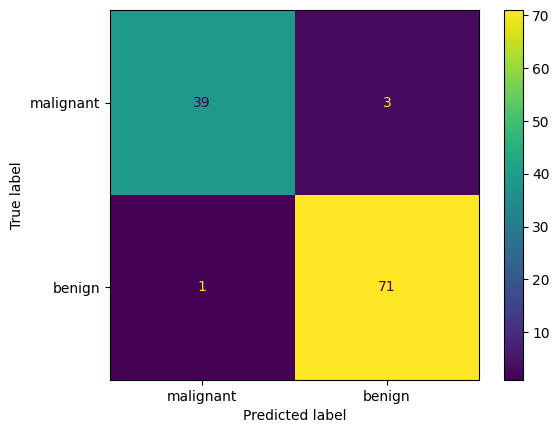

In [6]:
cm = confusion_matrix(y_true_np, y_pred_np)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["malignant", "benign"])
disp.plot()

# DEXIRE

In [7]:
import os
import sys
sys.path.insert(0, os.path.abspath('..'))

In [8]:
%load_ext autoreload
%autoreload 2
from dexire.dexire import DEXiRE

In [9]:
from dexire.adapters.pytorch_adapter import PyTorchModelAdapter
import numpy as np

In [10]:
adapter = PyTorchModelAdapter(model)
dexire = DEXiRE(model=adapter, class_names=['malignant', 'benign'])
print("y_train unique values:", np.unique(data["y_train"]))
print("class_names:", dexire.class_names)

y_train unique values: [0 1]
class_names: ['malignant', 'benign']


In [11]:
rules = dexire.extract_rules(data["X_train"], data["y_train"])

In [12]:
rules

[]

# DEXIRE-EXO

In [13]:
from dexire_exo.ga_engine import GAEngine
from dexire_exo.rule_formatter import format_if_elif_else
from sklearn.metrics import accuracy_score, classification_report
from src.config import Config

In [14]:
config = Config("config.yaml")
feature_names = range(X.shape[1])

In [15]:
engine = GAEngine(model_adapter=model, feature_names=feature_names, config=config)
best = engine.evolve(data["X_train"], data["y_train"])

AttributeError: 'NN' object has no attribute 'predict'

In [ ]:
y_pred_te, uncov_te = engine.predict_rules(best, data["X_test"])
mask = y_pred_te != -1
test_acc = accuracy_score(data["y_test"][mask], y_pred_te[mask]) if mask.any() else 0.0


In [ ]:
print("\nRules in IF–ELIF–ELSE form (GA):")
print(format_if_elif_else(best, feature_names, engine.operator_set))

In [ ]:
print("\n=== FINAL GA RESULTS ===")
print(f"Fidelity (train vs model): {best.fitness.values[0]:.3f}")
print(f"# Predicates             : {best.fitness.values[1]}")
print(f"Uncovered (train)        : {best.fitness.values[2]}")
print(f"Test accuracy (matched)  : {test_acc:.3f} | Uncov test: {uncov_te}")

In [ ]:
print(f"\nBest-by-generation CSV saved as: {config.ga_params.get('log_csv', 'ga_best_by_gen.csv')}")

In [ ]:
def greet(name, intensity):
    return "Hello, " + name + "!" * int(intensity)

In [ ]:
main = gr.Interface(
    fn=greet,
    inputs=["text", "slider"],
    outputs=["text"],
    api_name="predict"
)

In [ ]:
main.launch() # add share=True to have a public server 

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
